In [9]:
#Импортируем необходимые библиотеки
import torch
import torchvision
from torchvision import transforms
import random
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score,  confusion_matrix
import os
import matplotlib.pylab as plt
import seaborn as sns
from PIL import Image
import shutil

#Задаем seed для воспроизводимости
np.random.seed(222)
random.seed(222)
torch.manual_seed(222)
torch.cuda.manual_seed(222)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
#Данные уже организованы и разбиты на train, validation и test
for folder in os.listdir('data'):
    print(folder, " : ", os.listdir('data/'+ folder))

test  :  ['PNEUMONIA', 'NORMAL']
train  :  ['PNEUMONIA', 'NORMAL']
val  :  ['PNEUMONIA', 'NORMAL']


In [11]:
#Посмотрим на кол-во изображений
NORMAL = 0
PNEUMONIA = 0
for folder in os.listdir('data'):
    print(folder + '\t')
    for i in os.listdir('data/' + folder):
        print('\t', i, " : " + str(len(os.listdir('data/' + folder + '/' +i))))
        if(i == 'NORMAL'):
            NORMAL += len(os.listdir('data/' + folder + '/' + i))
        else:
            PNEUMONIA += len(os.listdir('data/' + folder + '/' + i))
    
print('\n', "NORMAL: ", NORMAL)
print("PNEUMONIA: ", PNEUMONIA)

test	
	 PNEUMONIA  : 390
	 NORMAL  : 234
train	
	 PNEUMONIA  : 3875
	 NORMAL  : 1341
val	
	 PNEUMONIA  : 8
	 NORMAL  : 8

 NORMAL:  1583
PNEUMONIA:  4273


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


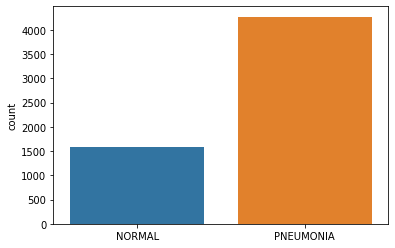

In [12]:
#Построим график для наглядности
sns.countplot(np.append(np.array(['NORMAL' for i in range(NORMAL)]), np.array(['PNEUMONIA' for j in range(PNEUMONIA)])));

Наблюдения:
- Набор данных несбалансирован, соотношение приблизительно 1 к 3.
- В валидации находится слишком мало данных для проверки -> случайность будет сильно искажать представление о результате обучения.

Выводы:
- Необходимо добавить в валидацию примеров (можно взять, например, из папки test или train)
- Необходимо сбалансировать обучающую выборку.

## Организация данных, dataloader

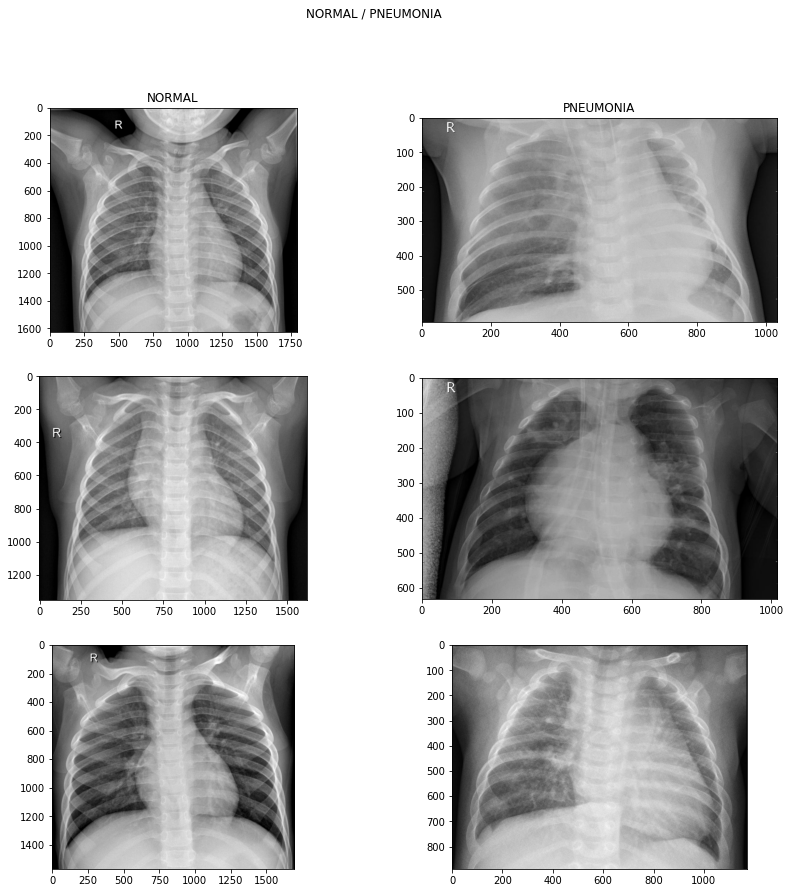

In [13]:
#Посмотрим на изображения
fig, axs = plt.subplots(3, 2, figsize = (14, 14))
axs[0,0].set_title("NORMAL")
axs[0,1].set_title("PNEUMONIA")
for i in range(3):
    temp_norm = 'data/train/NORMAL/' + os.listdir('data/train/NORMAL/')[np.random.randint(0, 200)]
    temp_pneum = 'data/train/PNEUMONIA/' + os.listdir('data/train/PNEUMONIA/')[np.random.randint(0, 200)]
    axs[i, 0].imshow(np.array(Image.open(temp_norm)), cmap = 'gray')
    axs[i, 1].imshow(np.array(Image.open(temp_pneum)), cmap = 'gray')
plt.suptitle('NORMAL / PNEUMONIA');

#### Перенесем немного данных из test в val
(не копируем)

In [14]:
#Посмотрим еще раз на кол-во изображений
print('test: ', 'NORMAL: ', len(os.listdir('data/test/NORMAL/')), "PNEUMONIA", len(os.listdir('data/test/PNEUMONIA')))
print('test: ', 'NORMAL: ', len(os.listdir('data/val/NORMAL/')), "PNEUMONIA", len(os.listdir('data/val/PNEUMONIA')))

test:  NORMAL:  234 PNEUMONIA 390
test:  NORMAL:  8 PNEUMONIA 8


In [15]:
#Перенесем по 42 изображения из test каждого класса в val

#NORMAL
order = np.random.permutation(len(os.listdir('data/test/NORMAL/')))[0:42] #Случайные индексы
for img in np.array(os.listdir('data/test/NORMAL'))[order]:
    shutil.move('data/test/NORMAL/' + img, 'data/val/NORMAL')
    
#PNEUMONIA
order = np.random.permutation(len(os.listdir('data/test/PNEUMONIA/')))[0:42] #Случайные индексы
for img in np.array(os.listdir('data/test/PNEUMONIA'))[order]:
    shutil.move('data/test/PNEUMONIA/' + img, 'data/val/PNEUMONIA')

In [16]:
#Посмотрим теперь на количество
print('test: ', 'NORMAL: ', len(os.listdir('data/test/NORMAL/')), "PNEUMONIA", len(os.listdir('data/test/PNEUMONIA')))
print('test: ', 'NORMAL: ', len(os.listdir('data/val/NORMAL/')), "PNEUMONIA", len(os.listdir('data/val/PNEUMONIA')))

test:  NORMAL:  192 PNEUMONIA 348
test:  NORMAL:  50 PNEUMONIA 50


Теперь результаты на валидации будут лучше отражать прогресс обучения нейронной сети, а в тестовой части осталось достаточно данных. Так как изображения были перенесены, а не скопированы, можно не бояться, что будем подстраиваться под тестовую выборку.

#### Сбалансируем классы в train

In [17]:
#Посмотрим еще раз на кол-во изображений
print('train: ', 'NORMAL: ', len(os.listdir('data/train/NORMAL/')), "PNEUMONIA", len(os.listdir('data/train/PNEUMONIA')))

train:  NORMAL:  1341 PNEUMONIA 3875


In [18]:
#Продублируем примеры из недостающего класса до сбалансированного количества
temp = os.listdir('data/train/NORMAL/')
for i in range(len(os.listdir('data/train/PNEUMONIA')) - len(os.listdir('data/train/NORMAL/'))):
    shutil.copyfile('data/train/NORMAL/'+ temp[np.random.randint(0, len(temp))],
                    'data/train/NORMAL/' + 'copy' + str(i) + '.jpeg')

In [19]:
#Посмотрим на баланс
print('train: ', 'NORMAL: ', len(os.listdir('data/train/NORMAL/')), "PNEUMONIA", len(os.listdir('data/train/PNEUMONIA')))

train:  NORMAL:  3875 PNEUMONIA 3875


### Dataloader

In [20]:
#Создаем dataloader для обучения и валидации
train_transform = transforms.Compose([
    #Аугментация
    transforms.RandomHorizontalFlip(p = 0.2),
    transforms.RandomApply(torch.nn.ModuleList([
        transforms.RandomRotation(degrees = (-15, 15))
    ]), p = 0.2),
    transforms.Resize((224, 224)), #формат моделей, обученных на ImageNet
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset = torchvision.datasets.ImageFolder('data/train/', train_transform)
val_dataset = torchvision.datasets.ImageFolder('data/val/', test_transform)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [21]:
#Посмотрим на размер изображения
train_dataset[1][0].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


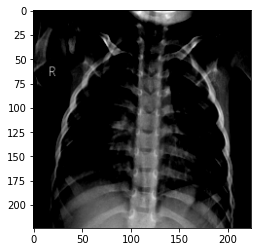

In [22]:
#Отрисуем какое-нибудь изображение
plt.imshow(train_dataset[np.random.randint(0, 100)][0].permute(1,2,0).numpy(), cmap = 'gray');

## Обучение

In [23]:
#Создадим класс для удобства обучения и сравнения моделей
class TrainVal:
    #Инициализируем модель, датасеты для обучения и валидации, оптимизатор, скорость обучения 
    def __init__(self, model, train, val, optimizer = 'Adam', lr = 0.005, weight_decay = 0):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #используемый девайс
        self.set_model(model) #Устанавливаем используемую архитектуру
        self.train = train #train dataloader
        self.val = val #validation dataloader
        self.set_optimizer(optimizer, lr, weight_decay) #Устанавливаем используемый оптимизатор
        self.loss = torch.nn.BCELoss() #loss функция
        self.sheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,
                                                       mode = 'max',
                                                       patience = 4,
                                                       verbose = True,
                                                       factor = 0.5, min_lr=0.00001) #Планировщик шага
        #Также переменные для анализа результатов
        self.loss_train = []
        self.loss_val = []
        self.f1_train = []
        self.f1_val = []
        self.recall_train = []
        self.recall_val = []
        self.precision_train = []
        self.precision_val = []
        
        self.name_model = model
        self.max_f1 = 0.85 #Для сохранения наилучшей модели

    #Устанавливаем модель
    def set_model(self, model):
        #resnet50, vgg-16, DenseNet, googlenet
        
        #resnet50
        if(model == 'resnet50'):
            self.model = torchvision.models.resnet50(pretrained = True) #Загружаем предобученный resnet50
            #Замораживаем все слои, кроме последнего
            for layer, param in self.model.named_parameters():
                if "layer" not in layer:
                    param.requires_grad = False
            #Последний слой заменяем под нашу задачу
            self.model.fc = torch.nn.Sequential(
                torch.nn.Linear(2048, 1024),
                torch.nn.ELU(),
                torch.nn.Dropout(p = 0.3),
                torch.nn.Linear(1024, 512),
                torch.nn.ELU(),
                torch.nn.Linear(512, 1),
                torch.nn.Sigmoid()
            )
            
            self.model = self.model.to(self.device) #переносим модель на используемый девайс

        #vgg16
        elif(model == "vgg16"):
            self.model = torchvision.models.vgg16(pretrained = True) #Загружаем предобученную vgg16
            #Замораживаем все слои, кроме последнего
            for layer, param in self.model.named_parameters():
                if "classifier" not in layer:
                    param.requires_grad = False
            #Заменяем последний слой под текущую задачу
            self.model.classifier = torch.nn.Sequential(
                torch.nn.Linear(25088, 4096),
                torch.nn.ELU(),
                torch.nn.Dropout(p = 0.5),
                torch.nn.Linear(4096, 2048),
                torch.nn.ELU(),
                torch.nn.Dropout(p = 0.5),
                torch.nn.Linear(2048, 512),
                torch.nn.ELU(),
                torch.nn.Linear(512, 1),
                torch.nn.Sigmoid()
            )
            
            self.model = self.model.to(self.device) #Переносим на девайс
        
        #densenet169
        elif(model == 'densenet169'):
            self.model = torchvision.models.densenet169(pretrained = True)

            for layer, param in self.model.named_parameters():
                if "classifier" not in layer:
                    param.requires_grad = False
            self.model.classifier = torch.nn.Sequential(
              torch.nn.Linear(1664, 832),
              torch.nn.ELU(),
              torch.nn.Dropout(p = 0.3),
              torch.nn.Linear(832, 208),
              torch.nn.ELU(),
              torch.nn.Linear(208, 1),
              torch.nn.Sigmoid()
          )
            self.model = self.model.to(self.device)
        
        #googlenet
        elif(model == 'googlenet'):
            self.model = torchvision.models.googlenet(pretrained = True)
            for layer, param in self.model.named_parameters():
                if "fc" not in layer:
                    param.requires_grad = False
            self.model.fc = torch.nn.Sequential(
              torch.nn.Linear(1024, 512),
              torch.nn.ELU(),
              torch.nn.Linear(512, 1),
              torch.nn.Sigmoid()
          )
            self.model = self.model.to(self.device)

        else:
            raise Exception("Данная архитектура не добавлена.")
    
    #Устанавливаем используемый оптимизатор
    def set_optimizer(self, optimizer, lr, weight_decay):
        if(optimizer == 'Adam'):
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr = lr, weight_decay = weight_decay)
    
    #Обучение
    def fit(self, num_epoch = 20):
        #Обучение
        for epoch in range(1, num_epoch+1):
            print("Epoch ", epoch)
            
            running_loss = 0
            real_classes = torch.tensor([], requires_grad = False)
            pred_classes = torch.tensor([], requires_grad = False)
            
            #Проходим по всей выборке
            for (idx, batch) in enumerate(self.train):

                self.model.train()
                imgs = batch[0].to(self.device) #Перекладываем батч на используемый девайс
                labels = batch[1].unsqueeze(1).float().to(self.device) #И также метки классов для батча
                
                self.optimizer.zero_grad() #Зануляем градиент
                
                prediction = self.model(imgs) #Делаем прогноз на батче
                loss_value = self.loss(prediction, labels) #Вычисляем loss-функцию
                #prediction = prediction.argmax(dim = 1)
                prediction = torch.round(prediction)
                
                loss_value.backward() #Вычисляем градиент
                self.optimizer.step() #Делаем шаг градиентного спуска
                
                running_loss += loss_value.item() #Увеличиваем loss
                pred_classes = torch.cat((pred_classes, prediction.cpu().detach()), dim = 0)
                real_classes = torch.cat((real_classes, labels.cpu().detach()), dim = 0)
            
            #Вычисляем loss по эпохе, а также такие метрики, как f1, recall и precision
            epoch_loss = running_loss / len(self.train)
            pred_classes = pred_classes.squeeze(1).cpu().detach().numpy()
            real_classes = real_classes.squeeze(1).cpu().detach().numpy()
            epoch_f1 = f1_score(real_classes, pred_classes)
            epoch_recall = recall_score(real_classes, pred_classes)
            epoch_precision = precision_score(real_classes, pred_classes)
            #Добавляем результаты
            self.loss_train.append(epoch_loss)
            self.f1_train.append(epoch_f1)
            self.recall_train.append(epoch_recall)
            self.precision_train.append(epoch_precision)
            
            print("{} Loss: {:.4f} f1: {:.4f}".format('Train', epoch_loss, epoch_f1))
            print("Recall: ", round(epoch_recall, 4), ' Precision: ', round(epoch_precision, 4), '\n')
            
            #Валидация
            running_loss = 0
            real_classes = torch.tensor([], requires_grad = False)
            pred_classes = torch.tensor([], requires_grad = False)
            #Проходим по всей валидационной выборке
            for (idx, batch) in enumerate(self.val):
                self.model.eval()
                imgs = batch[0].to(self.device) #Батч с изображениями
                labels = batch[1].unsqueeze(1).float().to(self.device) #И соответствующими метками классов
                prediction = self.model(imgs) #Прогноз
                loss_value = self.loss(prediction, labels) #Вычисляем loss
                #prediction = prediction.argmax(dim = 1)
                prediction = torch.round(prediction)
                running_loss += loss_value.item()
                pred_classes = torch.cat((pred_classes, prediction.cpu().detach()), dim = 0)
                real_classes = torch.cat((real_classes, labels.cpu().detach()), dim = 0)
            
            #Вычисляем loss по эпохе, а также такие метрики, как f1, recall и precision
            epoch_loss = running_loss / len(self.train)
            pred_classes = pred_classes.squeeze(1).cpu().detach().numpy()
            real_classes = real_classes.squeeze(1).cpu().detach().numpy()
            epoch_f1 = f1_score(real_classes, pred_classes)
            epoch_recall = recall_score(real_classes, pred_classes)
            epoch_precision = precision_score(real_classes, pred_classes)

            self.sheduler.step(epoch_f1) 
            #Добавляем результаты
            self.loss_val.append(epoch_loss)
            self.f1_val.append(epoch_f1)
            self.recall_val.append(epoch_recall)
            self.precision_val.append(epoch_precision)

            #Если модель лучше предыдущей лучшей, то сохраняем
            if(epoch_f1 >= self.max_f1):
                torch.save(self.model.state_dict(), "best_model_" + self.name_model +"_f1_" + str(round(epoch_f1, 2))+ ".pth")
                self.max_f1 = epoch_f1

            print("{} Loss: {:.4f} f1: {:.4f}".format('Validation', epoch_loss, epoch_f1))
            print("Recall: ", round(epoch_recall, 4), ' Precision: ', round(epoch_precision, 4), '\n')


    def get_hist_loss(self):
        return {'Train' : self.loss_train, 'Val' : self.loss_val}
    def get_hist_f1(self):
        return {'Train' : self.f1_train, 'Val' : self.f1_val}
    def get_hist_precision(self):
        return {'Train' : self.precision_train, 'Val' : self.precision_val}
    def get_hist_recall(self):
        return {'Train' : self.recall_train, 'Val' : self.recall_val}

    def get_model(self):
        return self.model

    #Разморозка всех слоев модели
    def unfreeze_layer(self):
        for layer, param in self.model.named_parameters():
            param.requires_grad = True

### Обучим 4 разные архитектуры и сравним полученные результаты

In [24]:
resnet50 = TrainVal('resnet50', train_dataloader, val_dataloader, 'Adam', 0.002)
vgg16 = TrainVal('vgg16', train_dataloader, val_dataloader, 'Adam', 0.002, 0.02)
DenseNet = TrainVal('densenet169', train_dataloader, val_dataloader, 'Adam', 0.002)
googlenet = TrainVal('googlenet', train_dataloader, val_dataloader, 'Adam', 0.002)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [25]:
resnet50.fit(15)

Epoch  1
Train Loss: 0.5899 f1: 0.8511
Recall:  0.8426  Precision:  0.8599 

Validation Loss: 0.0107 f1: 0.7603
Recall:  0.92  Precision:  0.6479 

Epoch  2
Train Loss: 0.2189 f1: 0.9154
Recall:  0.8996  Precision:  0.9318 

Validation Loss: 0.0068 f1: 0.8205
Recall:  0.96  Precision:  0.7164 

Epoch  3
Train Loss: 0.1900 f1: 0.9289
Recall:  0.9221  Precision:  0.9358 

Validation Loss: 0.0101 f1: 0.6667
Recall:  0.5  Precision:  1.0 

Epoch  4
Train Loss: 0.1735 f1: 0.9374
Recall:  0.9267  Precision:  0.9482 

Validation Loss: 0.0051 f1: 0.8448
Recall:  0.98  Precision:  0.7424 

Epoch  5
Train Loss: 0.1566 f1: 0.9431
Recall:  0.9347  Precision:  0.9517 

Validation Loss: 0.0061 f1: 0.8348
Recall:  0.96  Precision:  0.7385 

Epoch  6
Train Loss: 0.1387 f1: 0.9513
Recall:  0.9435  Precision:  0.9593 

Validation Loss: 0.0053 f1: 0.8542
Recall:  0.82  Precision:  0.8913 

Epoch  7
Train Loss: 0.1366 f1: 0.9523
Recall:  0.9463  Precision:  0.9584 

Validation Loss: 0.0045 f1: 0.8649
Reca

In [26]:
vgg16.fit(15)

Epoch  1
Train Loss: 8.5979 f1: 0.8271
Recall:  0.9035  Precision:  0.7626 

Validation Loss: 0.0062 f1: 0.7869
Recall:  0.96  Precision:  0.6667 

Epoch  2
Train Loss: 0.2708 f1: 0.8904
Recall:  0.9022  Precision:  0.8788 

Validation Loss: 0.0050 f1: 0.8932
Recall:  0.92  Precision:  0.8679 

Epoch  3
Train Loss: 34.9102 f1: 0.5136
Recall:  0.4212  Precision:  0.6581 

Validation Loss: 0.6443 f1: 0.6667
Recall:  1.0  Precision:  0.5 

Epoch  4
Train Loss: 48.2721 f1: 0.6624
Recall:  0.9799  Precision:  0.5003 

Validation Loss: 0.6443 f1: 0.6667
Recall:  1.0  Precision:  0.5 

Epoch  5
Train Loss: 2.7341 f1: 0.8246
Recall:  0.8462  Precision:  0.8041 

Validation Loss: 0.0110 f1: 0.7407
Recall:  1.0  Precision:  0.5882 

Epoch  6
Train Loss: 0.2841 f1: 0.8902
Recall:  0.8978  Precision:  0.8828 

Validation Loss: 0.0081 f1: 0.7805
Recall:  0.96  Precision:  0.6575 

Epoch  7
Train Loss: 0.2633 f1: 0.8992
Recall:  0.9032  Precision:  0.8951 

Epoch     7: reducing learning rate of gro

In [27]:
DenseNet.fit(15)

Epoch  1
Train Loss: 0.2612 f1: 0.8918
Recall:  0.8826  Precision:  0.9012 

Validation Loss: 0.0129 f1: 0.7353
Recall:  1.0  Precision:  0.5814 

Epoch  2
Train Loss: 0.1821 f1: 0.9337
Recall:  0.927  Precision:  0.9406 

Validation Loss: 0.0067 f1: 0.8348
Recall:  0.96  Precision:  0.7385 

Epoch  3
Train Loss: 0.1647 f1: 0.9370
Recall:  0.9295  Precision:  0.9447 

Validation Loss: 0.0054 f1: 0.8868
Recall:  0.94  Precision:  0.8393 

Epoch  4
Train Loss: 0.1685 f1: 0.9370
Recall:  0.9293  Precision:  0.9449 

Validation Loss: 0.0049 f1: 0.8704
Recall:  0.94  Precision:  0.8103 

Epoch  5
Train Loss: 0.1559 f1: 0.9404
Recall:  0.9306  Precision:  0.9504 

Validation Loss: 0.0079 f1: 0.7874
Recall:  1.0  Precision:  0.6494 

Epoch  6
Train Loss: 0.1514 f1: 0.9453
Recall:  0.9409  Precision:  0.9497 

Validation Loss: 0.0053 f1: 0.8496
Recall:  0.96  Precision:  0.7619 

Epoch  7
Train Loss: 0.1380 f1: 0.9453
Recall:  0.9435  Precision:  0.9472 

Validation Loss: 0.0068 f1: 0.7937
Rec

In [28]:
googlenet.fit(15)

Epoch  1
Train Loss: 0.2784 f1: 0.8822
Recall:  0.879  Precision:  0.8854 

Validation Loss: 0.0037 f1: 0.9278
Recall:  0.9  Precision:  0.9574 

Epoch  2
Train Loss: 0.2327 f1: 0.9083
Recall:  0.904  Precision:  0.9127 

Validation Loss: 0.0035 f1: 0.9245
Recall:  0.98  Precision:  0.875 

Epoch  3
Train Loss: 0.2106 f1: 0.9170
Recall:  0.9107  Precision:  0.9233 

Validation Loss: 0.0036 f1: 0.9293
Recall:  0.92  Precision:  0.9388 

Epoch  4
Train Loss: 0.2065 f1: 0.9183
Recall:  0.9102  Precision:  0.9265 

Validation Loss: 0.0046 f1: 0.8522
Recall:  0.98  Precision:  0.7538 

Epoch  5
Train Loss: 0.1809 f1: 0.9286
Recall:  0.9195  Precision:  0.9379 

Validation Loss: 0.0042 f1: 0.8829
Recall:  0.98  Precision:  0.8033 

Epoch  6
Train Loss: 0.1884 f1: 0.9258
Recall:  0.9172  Precision:  0.9345 

Validation Loss: 0.0037 f1: 0.9109
Recall:  0.92  Precision:  0.902 

Epoch  7
Train Loss: 0.1844 f1: 0.9274
Recall:  0.9195  Precision:  0.9354 

Validation Loss: 0.0044 f1: 0.8522
Recal

No handles with labels found to put in legend.


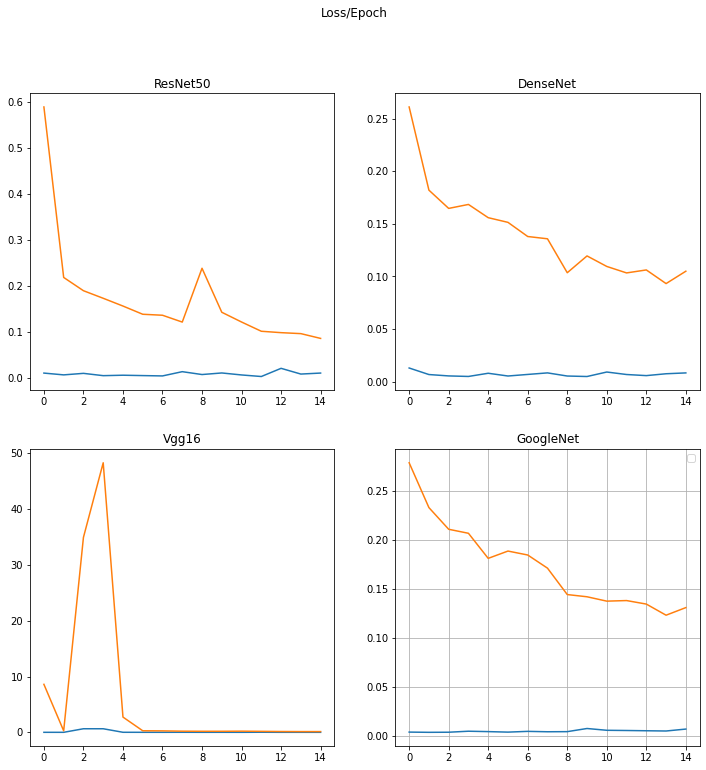

In [32]:
#Посмотрим на loss при обучении и валидации для обученных моделей
fig, axs = plt.subplots(2, 2, figsize = (12, 12))
plt.suptitle("Loss/Epoch")
axs[0,0].set_title('ResNet50')
axs[0,1].set_title('DenseNet')
axs[1,0].set_title("Vgg16")
axs[1,1].set_title('GoogleNet')

axs[0,0].plot(resnet50.get_hist_loss()['Val'])
axs[0,1].plot(DenseNet.get_hist_loss()['Val'])
axs[1,0].plot(vgg16.get_hist_loss()['Val'])
axs[1,1].plot(googlenet.get_hist_loss()['Val'])
axs[0,0].plot(resnet50.get_hist_loss()['Train'])
axs[0,1].plot(DenseNet.get_hist_loss()['Train'])
axs[1,0].plot(vgg16.get_hist_loss()['Train'])
axs[1,1].plot(googlenet.get_hist_loss()['Train'])
plt.legend()
plt.show()

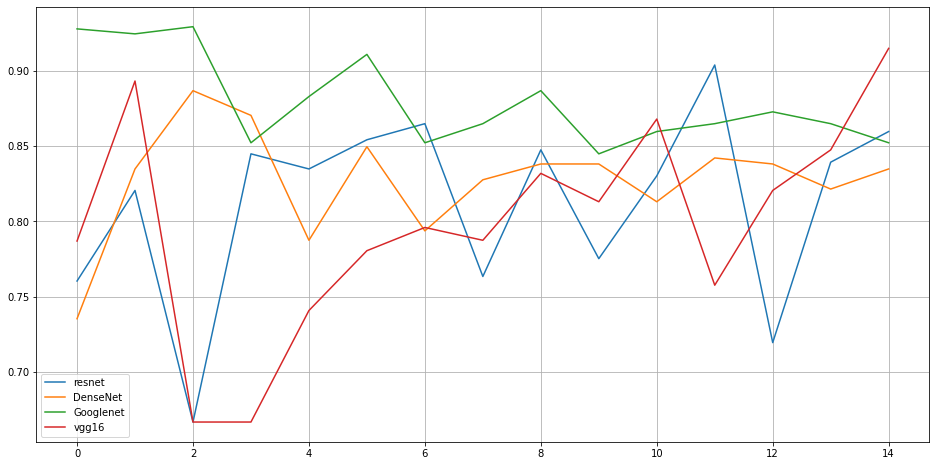

In [33]:
plt.figure(figsize = (16, 8))
plt.plot(resnet50.get_hist_f1()['Val'], label = 'resnet')
plt.plot(DenseNet.get_hist_f1()['Val'], label = 'DenseNet')
plt.plot(googlenet.get_hist_f1()['Val'], label = 'Googlenet')
plt.plot(vgg16.get_hist_f1()['Val'], label = 'vgg16')
plt.grid()
plt.legend()
plt.show()

Как видно из графика, googlenet показала себя лучше остальных, так как, во-первых, достигла за 15 эпох максимального качества среди всех четырех  архитектур, а также в среднем показывала в процессе обучения результаты лучше и стабильнее остальных моделей. Поэтому выбор пал именно на эту архитектуру для дальнейшего обучения.

In [36]:
#Загрузим веса с лучшим результатом и разморозим слои
googlenet.model.load_state_dict(torch.load('best_model_googlenet_f1_0.93.pth'))
googlenet.unfreeze_layer()
googlenet.fit(10)

Epoch  1
Train Loss: 0.1089 f1: 0.9573
Recall:  0.952  Precision:  0.9627 

Validation Loss: 0.0042 f1: 0.8738
Recall:  0.9  Precision:  0.8491 

Epoch  2
Train Loss: 0.0611 f1: 0.9784
Recall:  0.976  Precision:  0.9808 

Validation Loss: 0.0075 f1: 0.8727
Recall:  0.96  Precision:  0.8 

Epoch  3
Train Loss: 0.0386 f1: 0.9855
Recall:  0.9832  Precision:  0.9878 

Epoch    18: reducing learning rate of group 0 to 2.5000e-04.
Validation Loss: 0.0304 f1: 0.7874
Recall:  1.0  Precision:  0.6494 

Epoch  4
Train Loss: 0.0232 f1: 0.9928
Recall:  0.992  Precision:  0.9935 

Validation Loss: 0.0124 f1: 0.8333
Recall:  1.0  Precision:  0.7143 

Epoch  5
Train Loss: 0.0221 f1: 0.9928
Recall:  0.9912  Precision:  0.9943 

Validation Loss: 0.0132 f1: 0.8264
Recall:  1.0  Precision:  0.7042 

Epoch  6
Train Loss: 0.0153 f1: 0.9938
Recall:  0.9925  Precision:  0.9951 

Validation Loss: 0.0105 f1: 0.8333
Recall:  1.0  Precision:  0.7143 

Epoch  7
Train Loss: 0.0137 f1: 0.9947
Recall:  0.9941  Preci

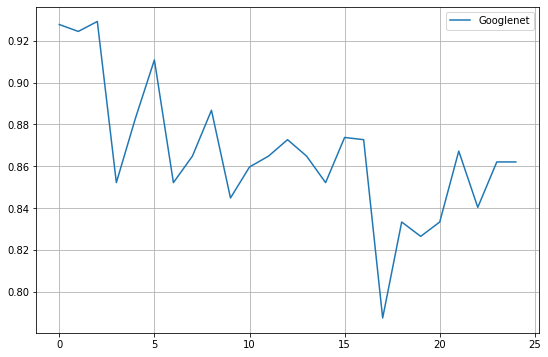

In [37]:
plt.figure(figsize = (9, 6))
plt.plot(googlenet.get_hist_f1()['Val'], label = 'Googlenet')
plt.grid()
plt.legend()
plt.show()

Модель заметно переобучается. Попробуем обучить заново, но добавив l2-регуляризацию и Dropout в последнем полносвязном слое.

In [44]:
googlenet = None
del googlenet
torch.cuda.empty_cache()

googlenet = TrainVal('googlenet', train_dataloader, val_dataloader, 'Adam', lr = 0.001, weight_decay = 0.005)
googlenet.model.fc = torch.nn.Sequential(
              torch.nn.Linear(1024, 512),
              torch.nn.ELU(),
              torch.nn.Dropout(p = 0.3),
              torch.nn.Linear(512, 1),
              torch.nn.Sigmoid()
          )
googlenet.model.to(googlenet.device)
googlenet.unfreeze_layer()
googlenet.fit(20)

Epoch  1
Train Loss: 0.2113 f1: 0.9323
Recall:  0.9283  Precision:  0.9365 

Validation Loss: 0.0081 f1: 0.6265
Recall:  0.52  Precision:  0.7879 

Epoch  2
Train Loss: 0.2408 f1: 0.9341
Recall:  0.9252  Precision:  0.9432 

Validation Loss: 0.0074 f1: 0.7717
Recall:  0.98  Precision:  0.6364 

Epoch  3
Train Loss: 0.2797 f1: 0.9386
Recall:  0.9326  Precision:  0.9446 

Validation Loss: 0.0071 f1: 0.7865
Recall:  0.7  Precision:  0.8974 

Epoch  4
Train Loss: 0.2956 f1: 0.9405
Recall:  0.9357  Precision:  0.9453 

Validation Loss: 0.0067 f1: 0.8571
Recall:  0.96  Precision:  0.7742 

Epoch  5
Train Loss: 0.2977 f1: 0.9419
Recall:  0.9357  Precision:  0.9482 

Validation Loss: 0.0092 f1: 0.6944
Recall:  1.0  Precision:  0.5319 

Epoch  6
Train Loss: 0.2857 f1: 0.9476
Recall:  0.9396  Precision:  0.9556 

Validation Loss: 0.0058 f1: 0.8750
Recall:  0.98  Precision:  0.7903 

Epoch  7
Train Loss: 0.2857 f1: 0.9487
Recall:  0.9448  Precision:  0.9526 

Validation Loss: 0.0064 f1: 0.8376
Re

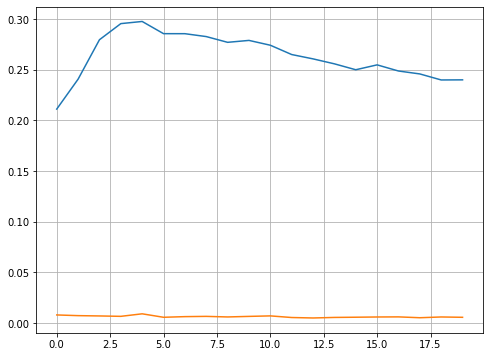

In [46]:
plt.figure(figsize = (8, 6))
plt.plot(googlenet.get_hist_loss()['Train'])
plt.plot(googlenet.get_hist_loss()['Val'])
plt.grid()
plt.show()

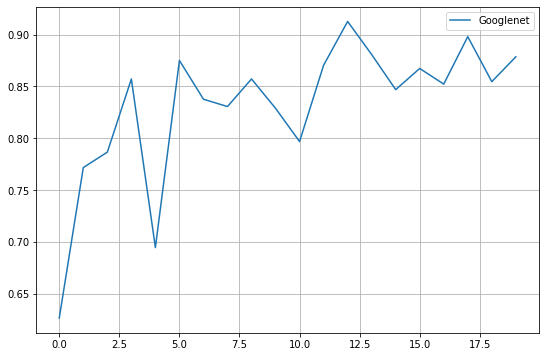

In [47]:
plt.figure(figsize = (9, 6))
plt.plot(googlenet.get_hist_f1()['Val'], label = 'Googlenet')
plt.grid()
plt.legend()
plt.show()

Модель с максимальным качеством уже сохранена, поэтому можно попробовать еще дообучить модель.

In [48]:
googlenet.fit(15)

Epoch  1
Train Loss: 0.2403 f1: 0.9783
Recall:  0.9757  Precision:  0.9808 

Validation Loss: 0.0062 f1: 0.8448
Recall:  0.98  Precision:  0.7424 

Epoch  2
Train Loss: 0.2399 f1: 0.9767
Recall:  0.9726  Precision:  0.9807 

Validation Loss: 0.0064 f1: 0.8130
Recall:  1.0  Precision:  0.6849 

Epoch  3
Train Loss: 0.2378 f1: 0.9768
Recall:  0.9708  Precision:  0.9828 

Epoch    23: reducing learning rate of group 0 to 1.2500e-04.
Validation Loss: 0.0054 f1: 0.8704
Recall:  0.94  Precision:  0.8103 

Epoch  4
Train Loss: 0.2358 f1: 0.9783
Recall:  0.9729  Precision:  0.9838 

Validation Loss: 0.0056 f1: 0.8807
Recall:  0.96  Precision:  0.8136 

Epoch  5
Train Loss: 0.2319 f1: 0.9833
Recall:  0.9796  Precision:  0.987 

Validation Loss: 0.0050 f1: 0.8762
Recall:  0.92  Precision:  0.8364 

Epoch  6
Train Loss: 0.2288 f1: 0.9843
Recall:  0.9806  Precision:  0.988 

Validation Loss: 0.0052 f1: 0.8889
Recall:  0.96  Precision:  0.8276 

Epoch  7
Train Loss: 0.2293 f1: 0.9839
Recall:  0.979

KeyboardInterrupt: ignored

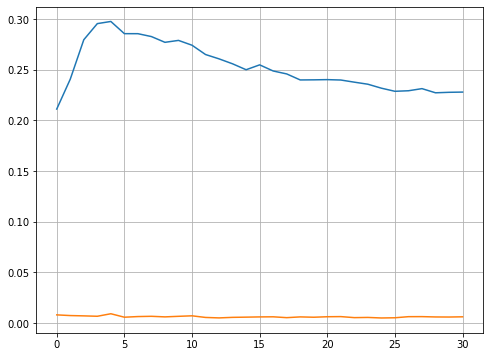

In [49]:
plt.figure(figsize = (8, 6))
plt.plot(googlenet.get_hist_loss()['Train'])
plt.plot(googlenet.get_hist_loss()['Val'])
plt.grid()
plt.show()

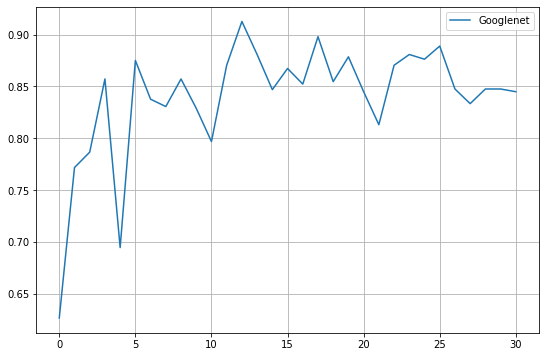

In [50]:
plt.figure(figsize = (9, 6))
plt.plot(googlenet.get_hist_f1()['Val'], label = 'Googlenet')
plt.grid()
plt.legend()
plt.show()

Качество не поднимается. Оставим модель с лучшим результатом (f1 = 0.91)

In [51]:
googlenet.model.load_state_dict(torch.load('best_model_googlenet_f1_0.91.pth'))

<All keys matched successfully>

In [53]:
#Тест
model = googlenet.get_model()

#Даталоадер для теста
test_dataset = torchvision.datasets.ImageFolder('data/test/', test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 10, shuffle = False)


real_classes = torch.tensor([], requires_grad = False)
pred_classes = torch.tensor([], requires_grad = False)

for (idx, batch) in enumerate(test_dataloader):
    model.eval()
    imgs = batch[0].to(device)
    labels = batch[1].unsqueeze(1).float().to(device)
    prediction = torch.round(model(imgs))
    pred_classes = torch.cat((pred_classes, prediction.cpu().detach()), dim = 0)
    real_classes = torch.cat((real_classes, labels.cpu().detach()), dim = 0)

pred_classes = pred_classes.squeeze(1).cpu().detach().numpy()
real_classes = real_classes.squeeze(1).cpu().detach().numpy()
f1 = f1_score(real_classes, pred_classes)
recall = recall_score(real_classes, pred_classes)
precision = precision_score(real_classes, pred_classes)

print('F1 score: ', round(f1, 3))
print("Recall: ", round(recall, 3))
print('Precision: ', round(precision, 3))

F1 score:  0.934
Recall:  0.974
Precision:  0.897


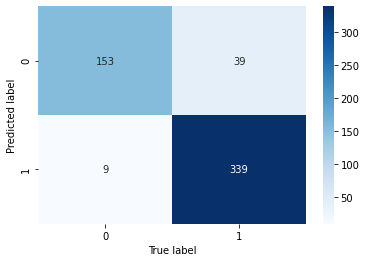

In [55]:
sns.heatmap(confusion_matrix(real_classes, pred_classes), annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()